# Esther's Text Processing Notebook Using Spacy

This notebook will focus on using Spacy for natural language processing.

### Importing and Installing

In [12]:
# Run in terminal for importing english pipeline, use of GPU, to train models
'''
!pip install -U pip setuptools wheel
!pip install -U 'spacy[cuda11x,transformers,lookups]'
!python -m spacy download en_core_web_trf
'''

ERROR: Invalid requirement: "'spacy[cuda11x,transformers,lookups]'"
c:\Users\esthe\AppData\Local\Programs\Python\Python311\python.exe: No module named spacy


In [4]:
import pandas as pd
import time
import numpy as np
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
import dropbox
import io
import os 

In [2]:
# load the english model
spacy.prefer_gpu()
nlp = spacy.load('en_core_web_trf')

C:\Users\esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


### Retrieving the Dataset from Dropbox + Cleaning

In [103]:
dropbox_access_token = ''

# Initialize Dropbox client
dbx = dropbox.Dropbox(dropbox_access_token)

# Dropbox file path
dropbox_file_path = '/fake_real_ML_project_dataset.csv'

# Download the file
metadata, response = dbx.files_download(dropbox_file_path)

# Read the CSV file from the response content using io.BytesIO
df = pd.read_csv(io.BytesIO(response.content))

# Show the results
print("Dataframe loaded from Dropbox:")
print(df.head())

Dataframe loaded from Dropbox:
   Unnamed: 0                                            Content  \
0           0  new york reuters us environmental group sierra...   
1           1  washington reuters us air force asked industry...   
2           2  saturday paul ryan posted photo instagram phot...   
3           3  america keeps waiting word hillary indicted ob...   
4           4                   religion peace ht weasel zippers   

          Title  Type  
0  politicsNews  true  
1  politicsNews  true  
2          News  fake  
3      politics  fake  
4     left-news  fake  


In [2]:
#%run C:\Users\esthe\DSEI2100_Project\machine-learning-dse-i210-final-project-fake-news\data\external\ML_dataset_dropbox.py

In [104]:
df = df.dropna()

In [105]:
# remove extra column
df = df.drop('Unnamed: 0', axis = 1)

In [106]:
df.head()

,Content,Title,Type
0,new york reuters us environmental group sierra...,politicsNews,true
1,washington reuters us air force asked industry...,politicsNews,true
2,saturday paul ryan posted photo instagram phot...,News,fake
3,america keeps waiting word hillary indicted ob...,politics,fake
4,religion peace ht weasel zippers,left-news,fake


In [ ]:
df.shape

(44266, 3)

Creating a smaller dataset to work with.

In [107]:
# Separate the DataFrame into two subsets based on categories
true_df = df[df['Type'] == 'true']
fake_df = df[df['Type'] == 'fake']

# Randomly sample an equal number of rows from each subset
sampled_true = true_df.sample(n=20, replace=False, random_state=42)
sampled_fake = fake_df.sample(n=20, replace=False, random_state=42)

# Combine the sampled rows into a single DataFrame
sampled_df = pd.concat([sampled_true, sampled_fake])

# Reset the index of the sampled DataFrame
sampled_df.reset_index(drop=True, inplace=True)

In [20]:
sampled_df.shape

(40, 3)

In [21]:
sampled_df.head()

,Content,Title,Type
0,washington reuters united states cannot trust ...,politicsNews,true
1,new york reuters email donald trump’s campaign...,politicsNews,true
2,stockholm reuters swedish court monday sentenc...,worldnews,true
3,washington reuters us president barack obama s...,politicsNews,true
4,bogotacartagena colombia reuters pope francis ...,worldnews,true


## Using Spacy

This section of the notebook will focus on using Spacy to process and extract information relevant to our goal of creating a fake news classification model.

We will use GPU to do these tasks and time them in order to compare them to our NLTK base.

### Spacy Tokenizer

In [108]:
sampled_df['Tokens'] = sampled_df['Content'].apply(lambda x: [token.text for token in nlp(x)])

In [25]:
sampled_df.head()

,Content,Title,Type,Tokens
0,washington reuters united states cannot trust ...,politicsNews,true,"[washington, reuters, united, states, can, not..."
1,new york reuters email donald trump’s campaign...,politicsNews,true,"[new, york, reuters, email, donald, trump, ’s,..."
2,stockholm reuters swedish court monday sentenc...,worldnews,true,"[stockholm, reuters, swedish, court, monday, s..."
3,washington reuters us president barack obama s...,politicsNews,true,"[washington, reuters, us, president, barack, o..."
4,bogotacartagena colombia reuters pope francis ...,worldnews,true,"[bogotacartagena, colombia, reuters, pope, fra..."


### Spacy Lemmatizer

In [109]:
# lemmatize the text (takes much longer to run than nltk)
def lemmatize_df(df):
    df['lemms'] = df['Content'].apply(lambda text: [token.lemma_ for token in nlp(text)])

In [110]:
lemmatize_df(sampled_df)

In [111]:
sampled_df.head()

,Content,Title,Type,Tokens,lemms
0,washington reuters united states cannot trust ...,politicsNews,true,"[washington, reuters, united, states, can, not...","[washington, reuters, united, states, can, not..."
1,new york reuters email donald trump’s campaign...,politicsNews,true,"[new, york, reuters, email, donald, trump, ’s,...","[new, york, reuters, email, donald, trump, ’s,..."
2,stockholm reuters swedish court monday sentenc...,worldnews,true,"[stockholm, reuters, swedish, court, monday, s...","[stockholm, reuters, swedish, court, monday, s..."
3,washington reuters us president barack obama s...,politicsNews,true,"[washington, reuters, us, president, barack, o...","[washington, reuters, us, president, barack, o..."
4,bogotacartagena colombia reuters pope francis ...,worldnews,true,"[bogotacartagena, colombia, reuters, pope, fra...","[bogotacartagena, colombia, reuters, pope, fra..."


### Spacy POS Tagging

In [112]:
# do pos tagging and convert it into a dictionary
sampled_df['pos_tag_dict'] = sampled_df['Content'].apply(lambda text: {token.text: token.pos_ for token in nlp(text)})

In [113]:
sampled_df['pos_tag_dict'].head()

0    {'washington': 'PROPN', 'reuters': 'PROPN', 'u...
1    {'new': 'ADJ', 'york': 'PROPN', 'reuters': 'PR...
2    {'stockholm': 'PROPN', 'reuters': 'PROPN', 'sw...
3    {'washington': 'PROPN', 'reuters': 'PROPN', 'u...
4    {'bogotacartagena': 'PROPN', 'colombia': 'PROP...
Name: pos_tag, dtype: object

In [133]:
sampled_df['POS_List'] = sampled_df['Content'].apply(lambda text: [token.pos_ for token in nlp(text)])

In [134]:
sampled_df['POS_List'].head()

0    [PROPN, PROPN, PROPN, PROPN, AUX, PART, VERB, ...
1    [PROPN, PROPN, PROPN, NOUN, PROPN, PROPN, PART...
2    [PROPN, PROPN, PROPN, PROPN, PROPN, VERB, ADJ,...
3    [PROPN, PROPN, PROPN, PROPN, PROPN, PROPN, VER...
4    [PROPN, PROPN, PROPN, PROPN, PROPN, PROPN, VER...
Name: POS_List, dtype: object

Create a df where every row is for a part of speech to use when visualizing.

In [135]:
pos_df = sampled_df.explode('POS_List')
pos_df.head()

,Content,Title,Type,Tokens,lemms,pos_tag,Entities_Dict,Entities_List,POS_List
0,washington reuters united states cannot trust ...,politicsNews,true,"[washington, reuters, united, states, can, not...","[washington, reuters, united, states, can, not...","{'washington': 'PROPN', 'reuters': 'PROPN', 'u...","{'washington': 'GPE', 'united': 'GPE', 'states...","[GPE, GPE, GPE, GPE, GPE, GPE, PERSON, PERSON,...",PROPN
0,washington reuters united states cannot trust ...,politicsNews,true,"[washington, reuters, united, states, can, not...","[washington, reuters, united, states, can, not...","{'washington': 'PROPN', 'reuters': 'PROPN', 'u...","{'washington': 'GPE', 'united': 'GPE', 'states...","[GPE, GPE, GPE, GPE, GPE, GPE, PERSON, PERSON,...",PROPN
0,washington reuters united states cannot trust ...,politicsNews,true,"[washington, reuters, united, states, can, not...","[washington, reuters, united, states, can, not...","{'washington': 'PROPN', 'reuters': 'PROPN', 'u...","{'washington': 'GPE', 'united': 'GPE', 'states...","[GPE, GPE, GPE, GPE, GPE, GPE, PERSON, PERSON,...",PROPN
0,washington reuters united states cannot trust ...,politicsNews,true,"[washington, reuters, united, states, can, not...","[washington, reuters, united, states, can, not...","{'washington': 'PROPN', 'reuters': 'PROPN', 'u...","{'washington': 'GPE', 'united': 'GPE', 'states...","[GPE, GPE, GPE, GPE, GPE, GPE, PERSON, PERSON,...",PROPN
0,washington reuters united states cannot trust ...,politicsNews,true,"[washington, reuters, united, states, can, not...","[washington, reuters, united, states, can, not...","{'washington': 'PROPN', 'reuters': 'PROPN', 'u...","{'washington': 'GPE', 'united': 'GPE', 'states...","[GPE, GPE, GPE, GPE, GPE, GPE, PERSON, PERSON,...",AUX


In [139]:
pos_fake_df = pos_df[pos_df['Type'] == 'fake']
pos_fake_df['Type'].head()

20    fake
20    fake
20    fake
20    fake
20    fake
Name: Type, dtype: object

In [145]:
pos_true_df = pos_df[pos_df['Type'] == 'true']
pos_true_df[['Type', 'POS_List']].head()

,Type,POS_List
0,true,PROPN
0,true,PROPN
0,true,PROPN
0,true,PROPN
0,true,AUX


Visualize which parts of speech are most used between fake news and real news.

In [160]:
pos_fake_df.groupby('POS_List').count().sort_values(by = 'Content', ascending = False)

,Content,Title,Type,Tokens,lemms,pos_tag,Entities_Dict,Entities_List
POS_List,,,,,,,,
NOUN,1144,1144,1144,1144,1144,1144,1144,1144
PROPN,1019,1019,1019,1019,1019,1019,1019,1019
VERB,777,777,777,777,777,777,777,777
ADJ,463,463,463,463,463,463,463,463
ADV,204,204,204,204,204,204,204,204
NUM,115,115,115,115,115,115,115,115
AUX,64,64,64,64,64,64,64,64
ADP,57,57,57,57,57,57,57,57
X,56,56,56,56,56,56,56,56


In [163]:
pos_true_df.groupby('POS_List').count().sort_values(by = 'Content', ascending = False)

,Content,Title,Type,Tokens,lemms,pos_tag,Entities_Dict,Entities_List
POS_List,,,,,,,,
NOUN,1120,1120,1120,1120,1120,1120,1120,1120
PROPN,1012,1012,1012,1012,1012,1012,1012,1012
VERB,744,744,744,744,744,744,744,744
ADJ,405,405,405,405,405,405,405,405
PUNCT,136,136,136,136,136,136,136,136
NUM,107,107,107,107,107,107,107,107
ADV,86,86,86,86,86,86,86,86
AUX,79,79,79,79,79,79,79,79
PART,61,61,61,61,61,61,61,61


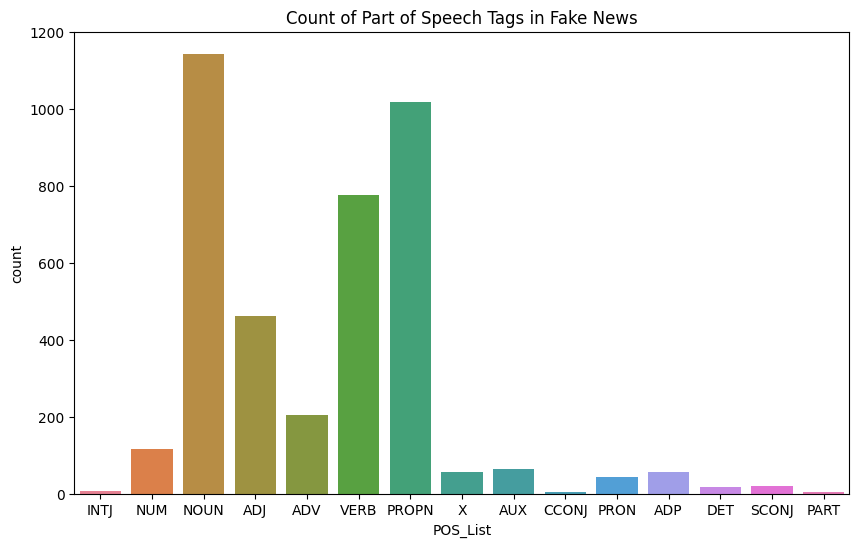

In [154]:
plt.figure(figsize=(10, 6))
sns.countplot(data=pos_fake_df, x='POS_List', hue='POS_List')
plt.title('Count of Part of Speech Tags in Fake News')
plt.show()

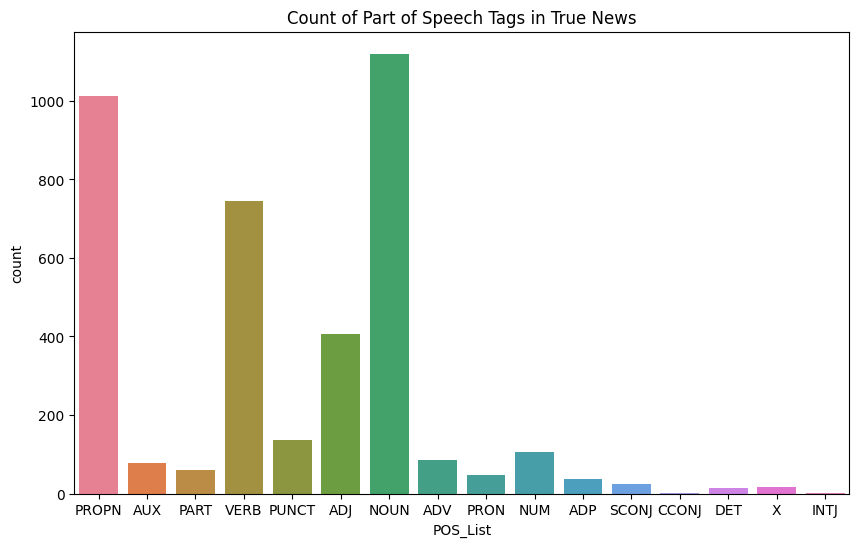

In [152]:
plt.figure(figsize=(10, 6))
sns.countplot(data=pos_true_df, x='POS_List', hue='POS_List')
plt.title('Count of Part of Speech Tags in True News')
plt.show()

It looks like fake news tends to use a lot less punctuation than real news.

### Spacy Entity Recognizer

spaCy's statistical entity recognition system assigns labels to contigouos spans of tokens. It works to identify a variety of named numeric entities including companies, locations, organizations, and products. In the context of our project, this is valuable as it will allow us to identify if there are any particular entities that are more prominent in fake news or real news.

- GPE: Geo-Political Entity. It refers to countries, cities, states, and other named places.
- PERSON: It indicates names of people, including fictional and real characters.
- DATE: Refers to specific dates or periods mentioned in the text.
- ORG: Represents organizations, companies, institutions, and similar entities.
- PERSON: Individual people, including fictional and real names.
- NORP: Nationalities or religious or political groups.
- FAC: Buildings, airports, highways, bridges, etc.
- ORG: Companies, agencies, institutions, etc.
- GPE: Countries, cities, states.
- LOC: Non-GPE locations, mountain ranges, bodies of water.
- PRODUCT: Objects, vehicles, foods, etc. (Not services.)
- EVENT: Named hurricanes, battles, wars, sports events, etc.
- WORK_OF_ART: Titles of books, songs, etc.
- LAW: Named documents made into laws.
- LANGUAGE: Any named language.

In [114]:
sampled_df['Entities_Dict'] = sampled_df['Content'].apply(lambda text: {token.text: token.ent_type_ for token in nlp(text)})


In [118]:
sampled_df['Entities_List'] = sampled_df['Content'].apply(lambda text: [token.ent_type_ for token in nlp(text)])

sampled_df['Entities_List']

Remove blank spaces in the list.

In [120]:
for index, entity_list in enumerate(sampled_df['Entities_List']):
    # Remove empty strings from the list
    cleaned_entity_list = [word for word in entity_list if word != '']
    # Update the 'Entities_List' column with the cleaned list
    sampled_df.at[index, 'Entities_List'] = cleaned_entity_list

In [ ]:
sampled_df['Entities_List']

Remove keys that have no assigned entity values.

In [125]:
def rmv_empty_ents(df):
    for _, row in df.iterrows():
        entities_copy = row['Entities_Dict'].copy()  # Create a copy of the dictionary
        for k, v in entities_copy.items():  # Iterate over the copy
            if v == '':
                del row['Entities_Dict'][k]  # Modify the original dictionary
    return df

In [ ]:
sampled_df = rmv_empty_ents(sampled_df)
sampled_df['Entities_Dict'].head()

In [ ]:
entities_df = sampled_df.explode('Entities_List')
entities_df.head()

In [ ]:
ent_df = sampled_df.explode('Entities_List')
ent_df.head()

In [ ]:
ent_fake_df = ent_df[ent_df['Type'] == 'fake']
ent_fake_df['Type'].head()

In [166]:
ent_true_df = ent_df[ent_df['Type'] == 'true']
ent_true_df['Type'].head()

0    true
0    true
0    true
0    true
0    true
Name: Type, dtype: object

In [183]:
ent_fake_df.groupby('Entities_List').count().sort_values(by = 'Content', ascending = False)

,Content,Title,Type,Tokens,lemms,pos_tag,Entities_Dict,POS_List
Entities_List,,,,,,,,
PERSON,401,401,401,401,401,401,401,401
ORG,212,212,212,212,212,212,212,212
DATE,136,136,136,136,136,136,136,136
GPE,91,91,91,91,91,91,91,91
CARDINAL,46,46,46,46,46,46,46,46
NORP,40,40,40,40,40,40,40,40
TIME,7,7,7,7,7,7,7,7
FAC,5,5,5,5,5,5,5,5
LAW,5,5,5,5,5,5,5,5


In [184]:
ent_true_df.groupby('Entities_List').count().sort_values(by = 'Content', ascending = False)

,Content,Title,Type,Tokens,lemms,pos_tag,Entities_Dict,POS_List
Entities_List,,,,,,,,
PERSON,317,317,317,317,317,317,317,317
ORG,241,241,241,241,241,241,241,241
GPE,181,181,181,181,181,181,181,181
DATE,146,146,146,146,146,146,146,146
NORP,77,77,77,77,77,77,77,77
CARDINAL,53,53,53,53,53,53,53,53
PRODUCT,19,19,19,19,19,19,19,19
MONEY,17,17,17,17,17,17,17,17
LAW,6,6,6,6,6,6,6,6


Visualize which entities pop up the most in fake news and which pop up the most in real news.

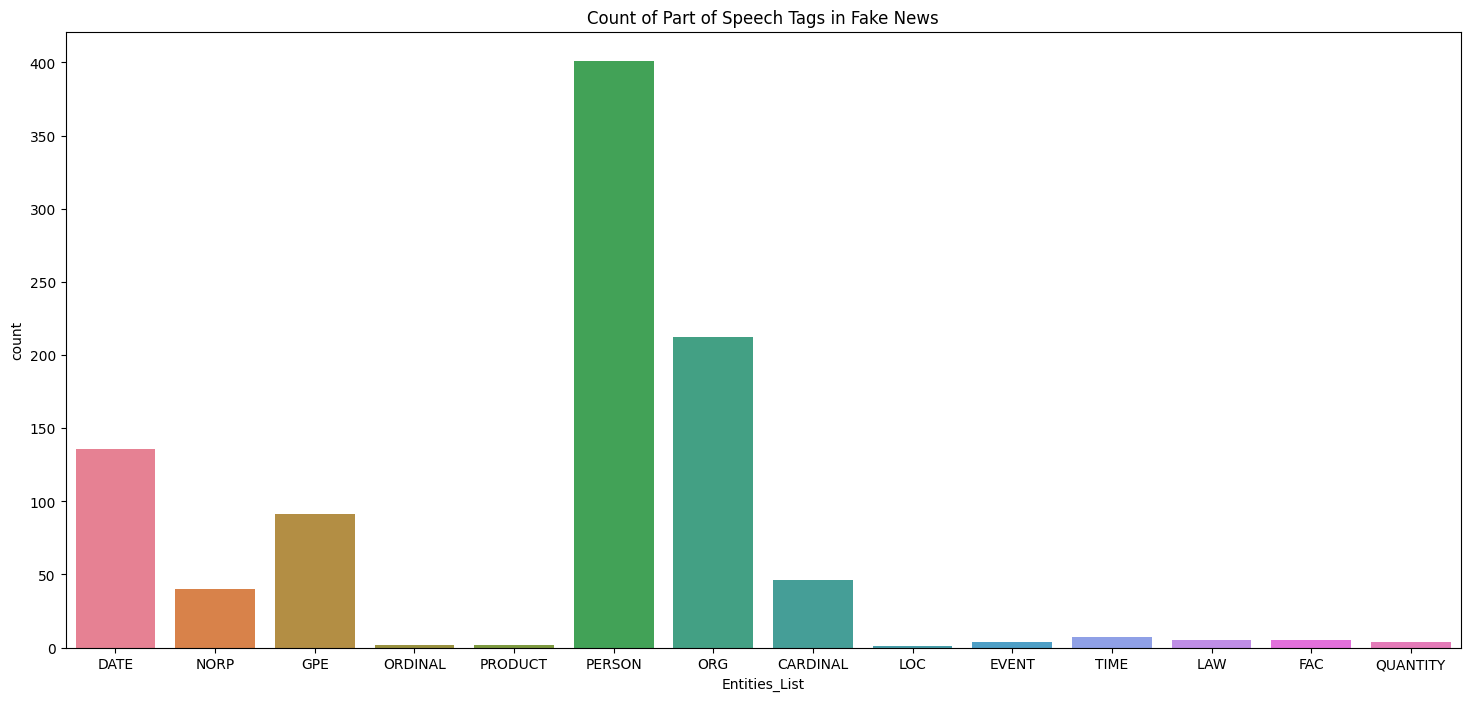

In [179]:
plt.figure(figsize=(18, 8))
sns.countplot(data=ent_fake_df, x='Entities_List', hue='Entities_List')
plt.title('Count of Part of Speech Tags in Fake News')
plt.show()

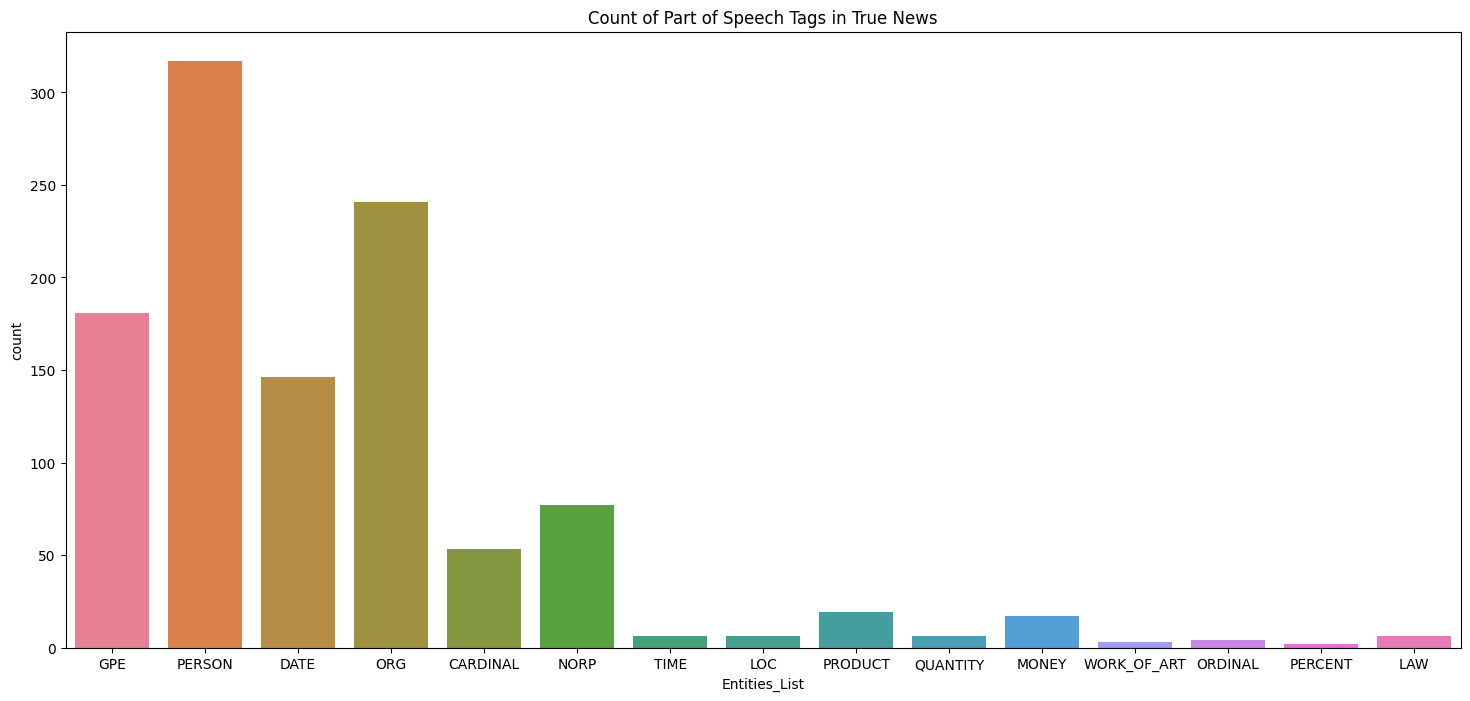

In [180]:
plt.figure(figsize=(18, 8))
sns.countplot(data=ent_true_df, x='Entities_List', hue='Entities_List')
plt.title('Count of Part of Speech Tags in True News')
plt.show()

### Spacy Text Categorizer

In [ ]:
on another notebook!!!